# Dimensionality Reduction Evaluation
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate dimensionality reduction techniques for their ability to preserve Euclidean structure of high-dimensional datasets.__  
  
To benchmark these techniques, we are using two single-cell RNAseq datasets:
* From [__Macosko, *et al* (2015)__](https://www.ncbi.nlm.nih.gov/pubmed/26000488), the mouse retina scRNA-seq data generated using DropSeq: [GSM1626793](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1626793)
* From [__Herring, *et al* (2018)__](https://www.ncbi.nlm.nih.gov/pubmed/29153838), the WT mouse colon scRNA-seq data generated using inDrops: [GSM2743164](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2743164)  
  
The first set should be __discrete__, containing highly separable cell populations from the mouse retina, where the latter will be __continuous__, representing a continuum of branching cell states in the gut epithelium.  
  
Both datasets have been __preprocessed and feature-selected__ to allow for direct input to downstream dimensionality reduction algorithms (rather than first performing PCA to limit dimensional input). These methods are shown in [`dev/QC.ipynb`](dev/QC.ipynb).

In [1]:
import sys
sys.path.append('../')
from fcc_DRs import *
%matplotlib inline

FIt-SNE repository not detected. Functionality will be disabled.


In [2]:
# read in Macosko retina data
retina = RNA_counts.from_file('../inputs/GSM1626793_P14Retina_1.processed.tsv', cells_axis=0, labels=[0,0])
# read in Herring colon data
colon = RNA_counts.from_file('../inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv', cells_axis=0, labels=[0,0])

In [3]:
# look at dimensions of counts matrix (cells, genes)
retina.data.shape

(1326, 500)

In [4]:
# look at dimensions of counts matrix (cells, genes)
colon.data.shape

(1117, 500)

---
### PCA
We'll look at principal component analysis (PCA) first, as a gold-standard. Because PCA performs a __linear__ transformation on the data, 500 PCs should perfectly preserve the overall dataset structure.

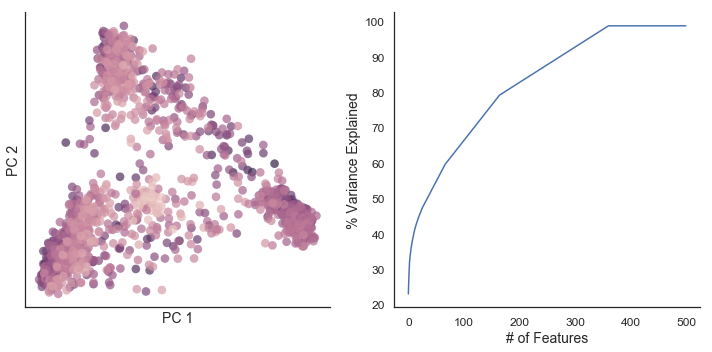

In [5]:
retina_PCA500 = fcc_PCA(retina.arcsinh_norm(), n_components=500)
retina_PCA500.plot_PCA()

We can test the Euclidean distance preservation as follows:

In [6]:
# choose value for K-nearest neighbor calculations. We use 30 because that is the standard perplexity chosen for DR techniques here.
k = 30

/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


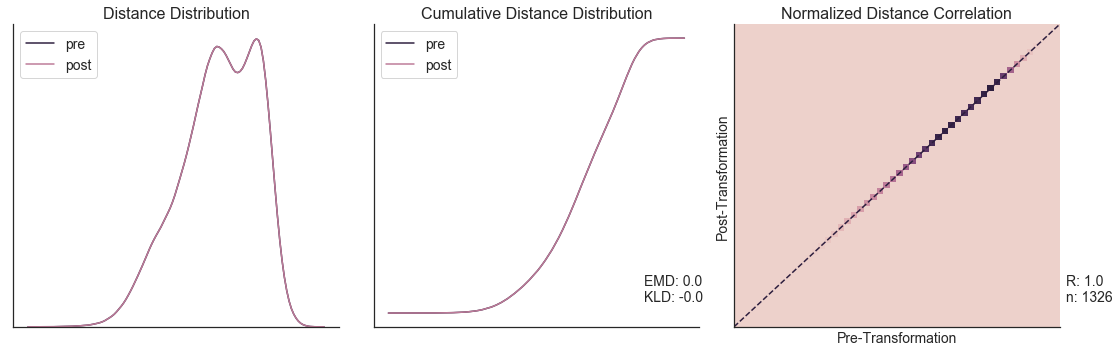

Knn Pres.: 100.0
CPU times: user 42.9 s, sys: 7.17 s, total: 50.1 s
Wall time: 49.8 s


In [7]:
%%time
mantel_stats, EMD, KLD = compare_euclid(pre=retina.distance_matrix(transform='arcsinh'), post=retina_PCA500.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_PCA500.knn_graph(k))
print('Knn Pres.: {}'.format(round(knn, 4)))

Now we can perform a PCA with a smaller number of components and determine the degree of information loss.  
The extreme example would be comparing only the __first two principal components__ to the original dataset:

In [21]:
# create dictionaries for dumping results into
final_distance_stats = {'Retina':{'R':{}, 'EMD':{}, 'KLD':{}, 'Knn Pres.':{}}, 'Colon':{'R':{}, 'EMD':{}, 'KLD':{}, 'Knn Pres.':{}}}

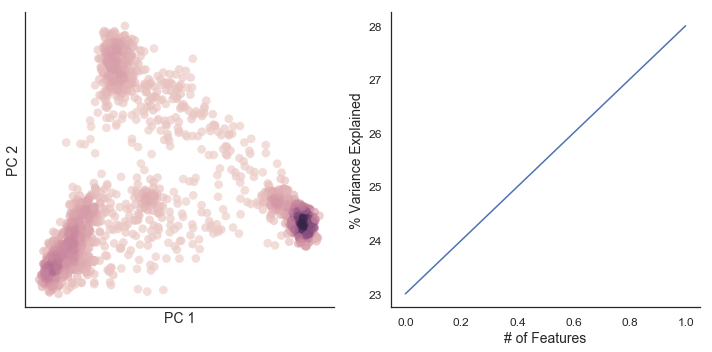

In [22]:
retina_PCA2 = fcc_PCA(retina.arcsinh_norm(), n_components=2)
retina_PCA2.plot_PCA()

In [23]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_PCA2.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_PCA2.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['PCA (2)'], final_distance_stats['Retina']['EMD']['PCA (2)'], final_distance_stats['Retina']['KLD']['PCA (2)'], final_distance_stats['Retina']['Knn Pres.']['PCA (2)'] = mantel_stats[0], EMD, KLD, knn

R: 0.7718
EMD: 0.2231
KLD: 0.1929
Knn Pres.: 96.7996
CPU times: user 37.3 s, sys: 7.04 s, total: 44.4 s
Wall time: 44.7 s


CPU times: user 18.4 s, sys: 384 ms, total: 18.8 s
Wall time: 18.1 s


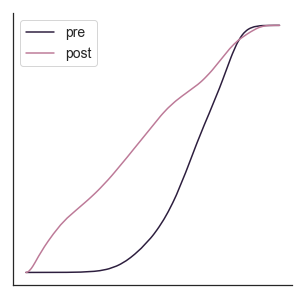

<Figure size 504x504 with 0 Axes>

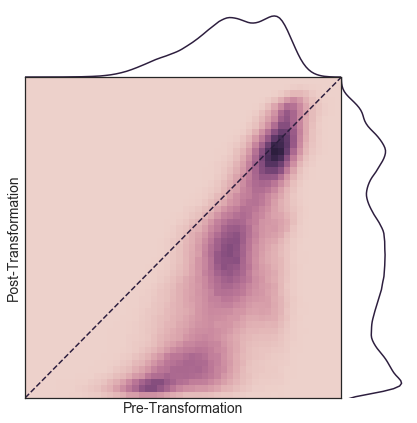

In [24]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_PCA2_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_PCA2_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

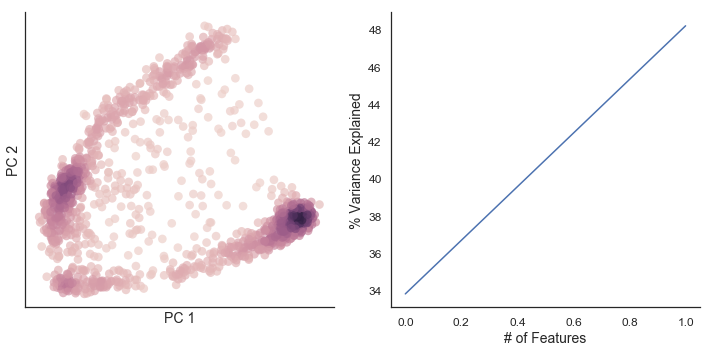

In [25]:
colon_PCA2 = fcc_PCA(colon.arcsinh_norm(), n_components=2)
colon_PCA2.plot_PCA()

In [26]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_PCA2.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_PCA2.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['PCA (2)'], final_distance_stats['Colon']['EMD']['PCA (2)'], final_distance_stats['Colon']['KLD']['PCA (2)'], final_distance_stats['Colon']['Knn Pres.']['PCA (2)'] = mantel_stats[0], EMD, KLD, knn

R: 0.9381
EMD: 0.0635
KLD: 0.0594
Knn Pres.: 97.529
CPU times: user 23.5 s, sys: 4.55 s, total: 28.1 s
Wall time: 28.1 s


CPU times: user 18.1 s, sys: 399 ms, total: 18.5 s
Wall time: 17.8 s


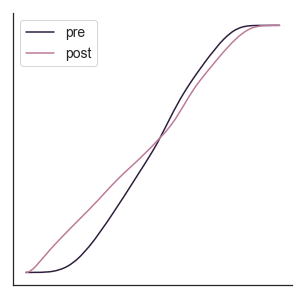

<Figure size 504x504 with 0 Axes>

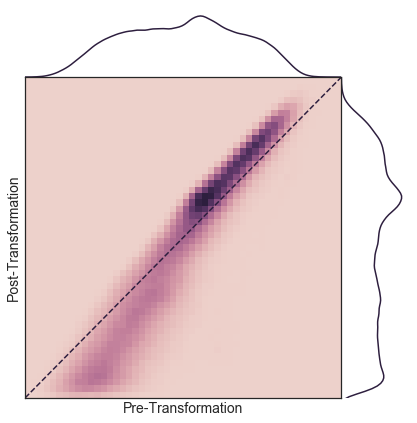

In [27]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_PCA2_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_PCA2_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

Now let's do __10 PCs__ to compare to __scVI__ output, which is the only DR method we have that can't return a 2D embedding:

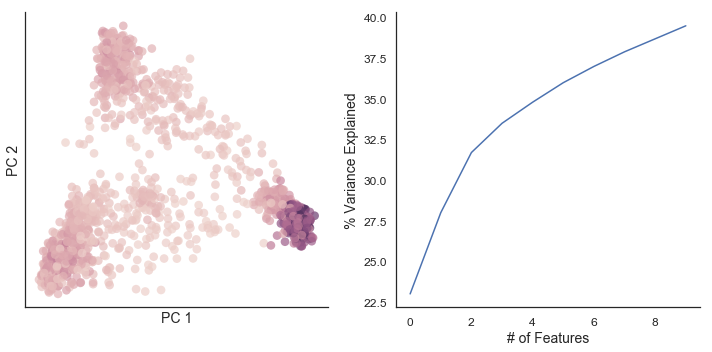

In [28]:
retina_PCA10 = fcc_PCA(retina.arcsinh_norm(), n_components=10)
retina_PCA10.plot_PCA()

In [29]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_PCA10.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_PCA10.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['PCA (10)'], final_distance_stats['Retina']['EMD']['PCA (10)'], final_distance_stats['Retina']['KLD']['PCA (10)'], final_distance_stats['Retina']['Knn Pres.']['PCA (10)'] = mantel_stats[0], EMD, KLD, knn

R: 0.8557
EMD: 0.166
KLD: 0.0544
Knn Pres.: 97.4037
CPU times: user 36.9 s, sys: 6.76 s, total: 43.7 s
Wall time: 43.8 s


CPU times: user 18.5 s, sys: 365 ms, total: 18.9 s
Wall time: 18.1 s


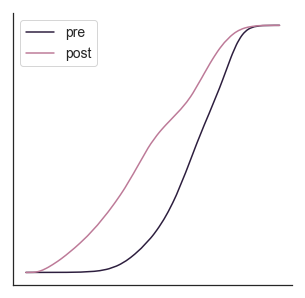

<Figure size 504x504 with 0 Axes>

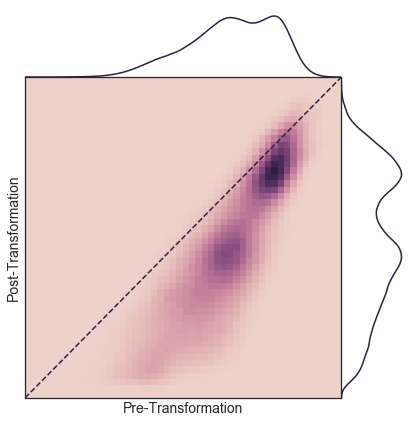

In [30]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_PCA10_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_PCA10_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

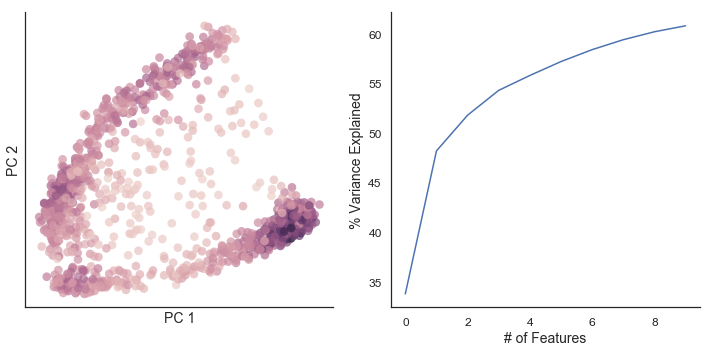

In [31]:
colon_PCA10 = fcc_PCA(colon.arcsinh_norm(), n_components=10)
colon_PCA10.plot_PCA()

In [32]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_PCA10.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_PCA10.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['PCA (10)'], final_distance_stats['Colon']['EMD']['PCA (10)'], final_distance_stats['Colon']['KLD']['PCA (10)'], final_distance_stats['Colon']['Knn Pres.']['PCA (10)'] = mantel_stats[0], EMD, KLD, knn

R: 0.9688
EMD: 0.0375
KLD: 0.0101
Knn Pres.: 98.0704
CPU times: user 23.9 s, sys: 4.38 s, total: 28.3 s
Wall time: 28.3 s


CPU times: user 18.1 s, sys: 365 ms, total: 18.5 s
Wall time: 17.8 s


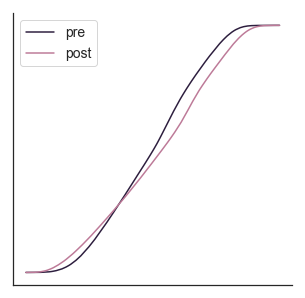

<Figure size 504x504 with 0 Axes>

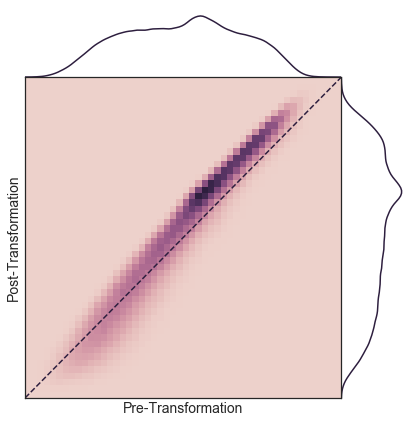

In [33]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_PCA10_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_PCA10_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# t-SNE
A workhorse technique for dimensionality reduction and visualization of scRNA-seq datasets, t-SNE performs a stochastic, non-linear transformation to project high-dimensional data into 2D in order to identify clustering and global structure.  
Here, we will plug arcsinh-normalized counts data directly into t-SNE and compare results to the original, feature-selected dataset.

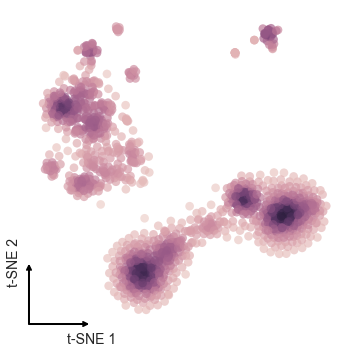

In [34]:
retina_tSNE = DR.from_file('pymethods_out/retina_tSNE.csv', name='t-SNE', labels=[None,None])
retina_tSNE.plot()

In [35]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_tSNE.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_tSNE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['t-SNE'], final_distance_stats['Retina']['EMD']['t-SNE'], final_distance_stats['Retina']['KLD']['t-SNE'], final_distance_stats['Retina']['Knn Pres.']['t-SNE'] = mantel_stats[0], EMD, KLD, knn

R: 0.7739
EMD: 0.2165
KLD: 0.1366
Knn Pres.: 96.8218
CPU times: user 36.2 s, sys: 6.35 s, total: 42.5 s
Wall time: 42.6 s


CPU times: user 18.3 s, sys: 418 ms, total: 18.8 s
Wall time: 18.1 s


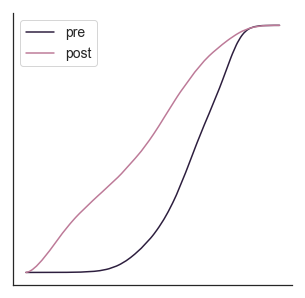

<Figure size 504x504 with 0 Axes>

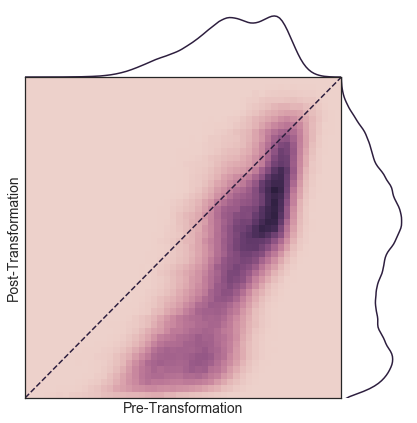

In [36]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_tSNE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_tSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

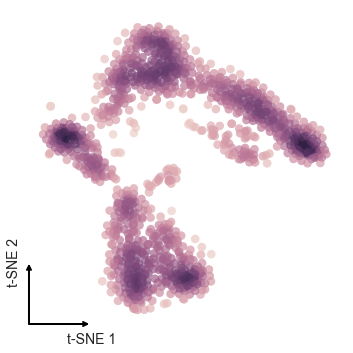

In [37]:
colon_tSNE = DR.from_file('pymethods_out/colon_tSNE.csv', name='t-SNE', labels=[None,None])
colon_tSNE.plot()

In [38]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_tSNE.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_tSNE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['t-SNE'], final_distance_stats['Colon']['EMD']['t-SNE'], final_distance_stats['Colon']['KLD']['t-SNE'], final_distance_stats['Colon']['Knn Pres.']['t-SNE'] = mantel_stats[0], EMD, KLD, knn

R: 0.8816
EMD: 0.0822
KLD: 0.0516
Knn Pres.: 97.1733
CPU times: user 23.5 s, sys: 4.31 s, total: 27.8 s
Wall time: 27.8 s


CPU times: user 18 s, sys: 351 ms, total: 18.4 s
Wall time: 17.7 s


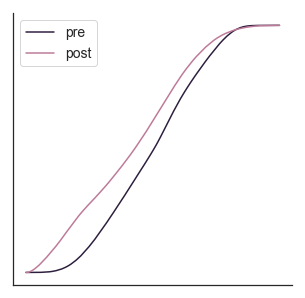

<Figure size 504x504 with 0 Axes>

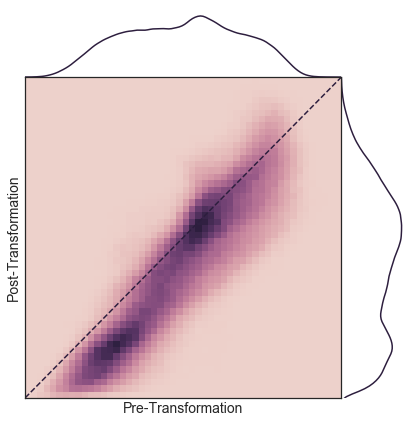

In [39]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_tSNE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_tSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# FIt-SNE
A workhorse technique for dimensionality reduction and visualization of scRNA-seq datasets, t-SNE performs a stochastic, non-linear transformation to project high-dimensional data into 2D in order to identify clustering and global structure. The FIt-SNE implementation is supposed to be faster and more efficient.  
Here, we will plug arcsinh-normalized counts data directly into t-SNE and compare results to the original, feature-selected dataset.

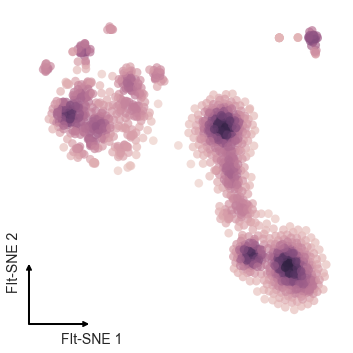

In [40]:
retina_FItSNE = DR.from_file('pymethods_out/retina_FItSNE.csv', name='FIt-SNE', labels=[None,None])
retina_FItSNE.plot()

In [41]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_FItSNE.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_FItSNE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['FIt-SNE'], final_distance_stats['Retina']['EMD']['FIt-SNE'], final_distance_stats['Retina']['KLD']['FIt-SNE'], final_distance_stats['Retina']['Knn Pres.']['FIt-SNE'] = mantel_stats[0], EMD, KLD, knn

R: 0.782
EMD: 0.2708
KLD: 0.1576
Knn Pres.: 96.8063
CPU times: user 36 s, sys: 6.37 s, total: 42.4 s
Wall time: 42.4 s


CPU times: user 18.4 s, sys: 374 ms, total: 18.8 s
Wall time: 18.1 s


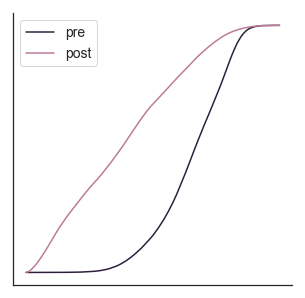

<Figure size 504x504 with 0 Axes>

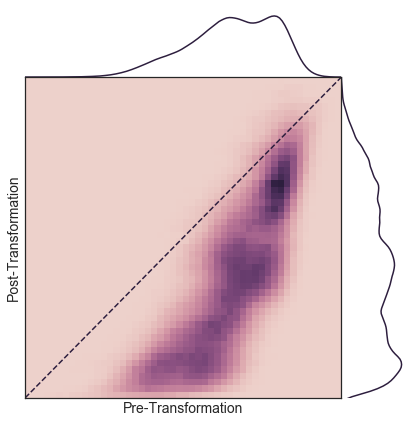

In [42]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_FItSNE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_FItSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

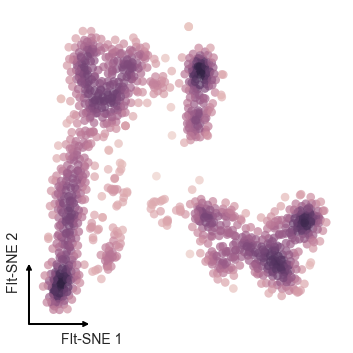

In [43]:
colon_FItSNE = DR.from_file('pymethods_out/colon_FItSNE.csv', name='FIt-SNE', labels=[None,None])
colon_FItSNE.plot()

In [44]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_FItSNE.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_FItSNE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['FIt-SNE'], final_distance_stats['Colon']['EMD']['FIt-SNE'], final_distance_stats['Colon']['KLD']['FIt-SNE'], final_distance_stats['Colon']['Knn Pres.']['FIt-SNE'] = mantel_stats[0], EMD, KLD, knn

R: 0.8438
EMD: 0.0691
KLD: 0.0582
Knn Pres.: 97.148
CPU times: user 23.8 s, sys: 4.66 s, total: 28.4 s
Wall time: 28.5 s


CPU times: user 18.1 s, sys: 380 ms, total: 18.5 s
Wall time: 17.8 s


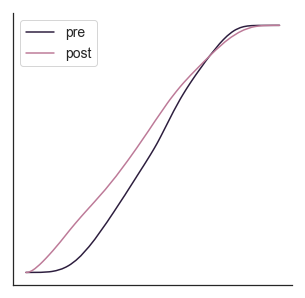

<Figure size 504x504 with 0 Axes>

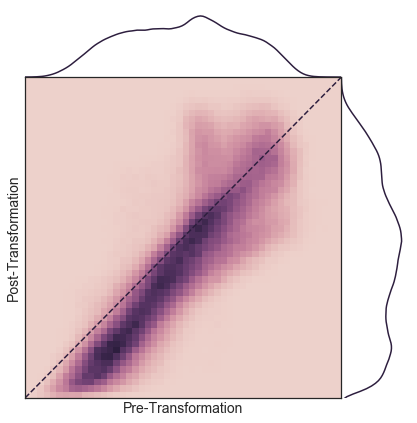

In [45]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_FItSNE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_FItSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# UMAP
Another popular method for low-dimensional projection of scRNA-seq datasets, UMAP creates high-dimensional manifolds that describe the structure of the dataset.  
Here, we will plug arcsinh-normalized counts data directly into UMAP and compare results to the original, feature-selected dataset.

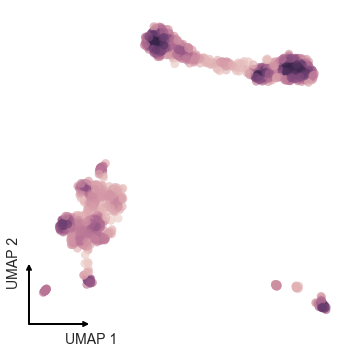

In [46]:
retina_UMAP = DR.from_file('pymethods_out/retina_UMAP.csv', name='UMAP', labels=[None,None])
retina_UMAP.plot()

In [47]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_UMAP.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_UMAP.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['UMAP'], final_distance_stats['Retina']['EMD']['UMAP'], final_distance_stats['Retina']['KLD']['UMAP'], final_distance_stats['Retina']['Knn Pres.']['UMAP'] = mantel_stats[0], EMD, KLD, knn

R: 0.7269
EMD: 0.2247
KLD: 0.2474
Knn Pres.: 96.6672
CPU times: user 36.5 s, sys: 7.05 s, total: 43.6 s
Wall time: 43.6 s


CPU times: user 18.5 s, sys: 394 ms, total: 18.9 s
Wall time: 18.2 s


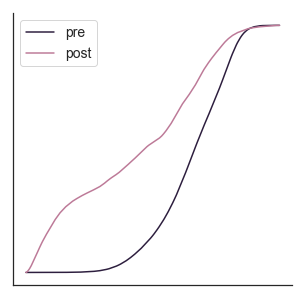

<Figure size 504x504 with 0 Axes>

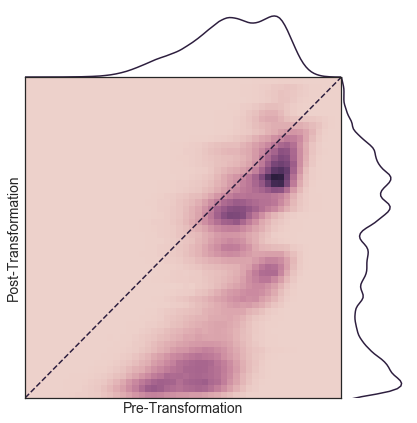

In [48]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_UMAP_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_UMAP_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

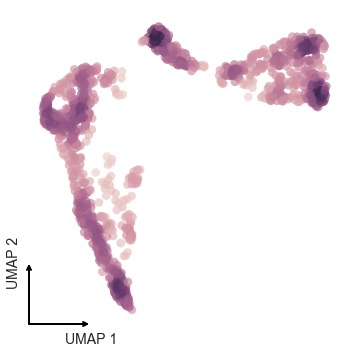

In [49]:
colon_UMAP = DR.from_file('pymethods_out/colon_UMAP.csv', name='UMAP', labels=[None,None])
colon_UMAP.plot()

In [50]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_UMAP.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_UMAP.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['UMAP'], final_distance_stats['Colon']['EMD']['UMAP'], final_distance_stats['Colon']['KLD']['UMAP'], final_distance_stats['Colon']['Knn Pres.']['UMAP'] = mantel_stats[0], EMD, KLD, knn

R: 0.8002
EMD: 0.0936
KLD: 0.0998
Knn Pres.: 97.1171
CPU times: user 23.4 s, sys: 4.32 s, total: 27.7 s
Wall time: 27.8 s


CPU times: user 18.8 s, sys: 404 ms, total: 19.2 s
Wall time: 18.7 s


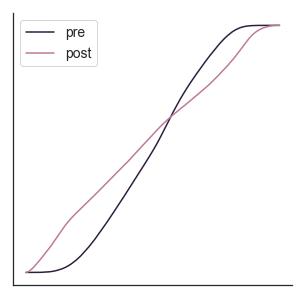

<Figure size 504x504 with 0 Axes>

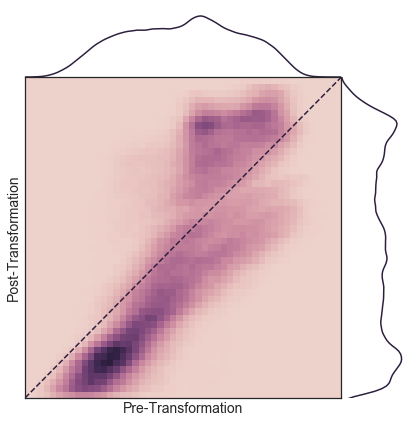

In [51]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_UMAP_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_UMAP_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# ZIFA
This method uses the zero-inflated negative binomial distribution to reduce RNA counts data to lower dimensions.  
Here, we will plug arcsinh-normalized counts data directly into ZIFA and compare results to the original, feature-selected dataset.

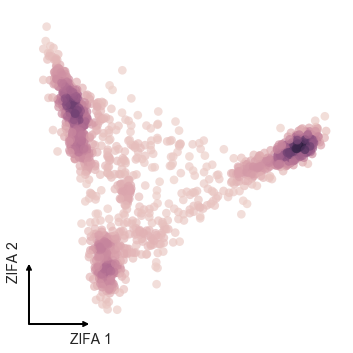

In [52]:
retina_ZIFA = DR.from_file('pymethods_out/retina_ZIFA.csv', name='ZIFA', labels=[None,None])
retina_ZIFA.plot()

In [53]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='log2'), post=retina_ZIFA.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='log2'), post=retina_ZIFA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['ZIFA'], final_distance_stats['Retina']['EMD']['ZIFA'], final_distance_stats['Retina']['KLD']['ZIFA'], final_distance_stats['Retina']['Knn Pres.']['ZIFA'] = mantel_stats[0], EMD, KLD, knn

R: 0.4224
EMD: 0.1539
KLD: 0.1918
Knn Pres.: 96.3503
CPU times: user 37.1 s, sys: 7.08 s, total: 44.2 s
Wall time: 44.2 s


CPU times: user 17.9 s, sys: 424 ms, total: 18.3 s
Wall time: 17.7 s


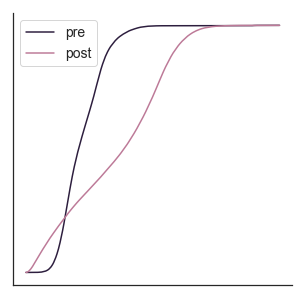

<Figure size 504x504 with 0 Axes>

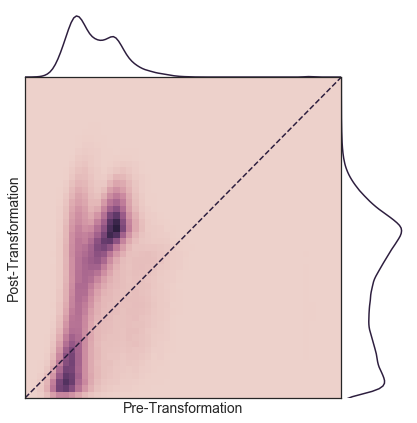

In [54]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_ZIFA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_ZIFA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

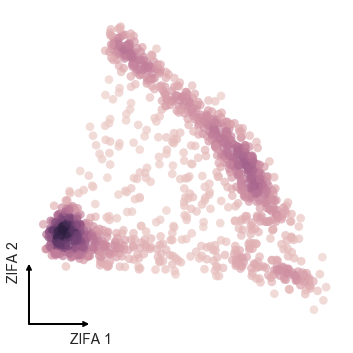

In [55]:
colon_ZIFA = DR.from_file('pymethods_out/colon_ZIFA.csv', name='ZIFA', labels=[None,None])
colon_ZIFA.plot()

In [57]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='log2'), post=colon_ZIFA.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='log2'), post=colon_ZIFA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['ZIFA'], final_distance_stats['Colon']['EMD']['ZIFA'], final_distance_stats['Colon']['KLD']['ZIFA'], final_distance_stats['Colon']['Knn Pres.']['ZIFA'] = mantel_stats[0], EMD, KLD, knn

R: 0.6099
EMD: 0.1329
KLD: 0.1354
Knn Pres.: 96.1399
CPU times: user 24 s, sys: 5.13 s, total: 29.2 s
Wall time: 29.3 s


CPU times: user 17.9 s, sys: 469 ms, total: 18.4 s
Wall time: 17.8 s


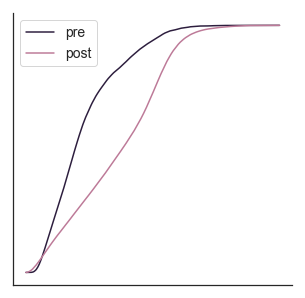

<Figure size 504x504 with 0 Axes>

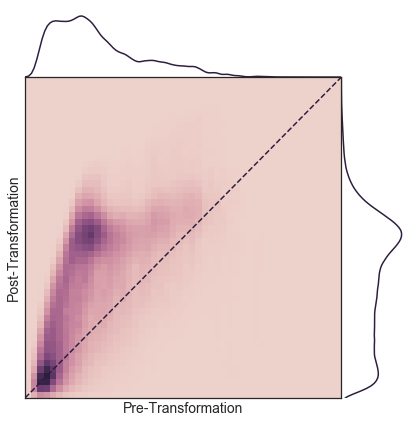

In [58]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_ZIFA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_ZIFA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# DCA
This method uses a deep count autoencoder to reduce RNA counts data to lower dimensions.  
Here, we will plug counts data directly into DCA and compare results to the original, feature-selected dataset.

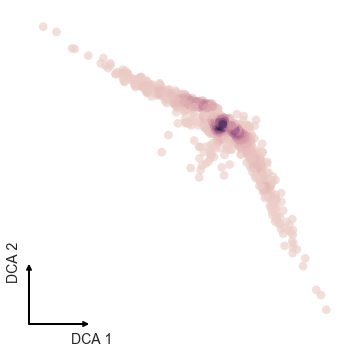

In [59]:
retina_DCA = DR.from_file('pymethods_out/retina_DCA.csv', name='DCA', labels=[None,None])
retina_DCA.plot()

In [60]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_DCA.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_DCA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['DCA'], final_distance_stats['Retina']['EMD']['DCA'], final_distance_stats['Retina']['KLD']['DCA'], final_distance_stats['Retina']['Knn Pres.']['DCA'] = mantel_stats[0], EMD, KLD, knn

R: 0.745
EMD: 0.0276
KLD: 0.1722
Knn Pres.: 96.411
CPU times: user 39 s, sys: 8.21 s, total: 47.2 s
Wall time: 47.4 s


CPU times: user 17.7 s, sys: 425 ms, total: 18.1 s
Wall time: 17.5 s


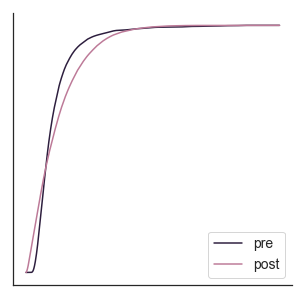

<Figure size 504x504 with 0 Axes>

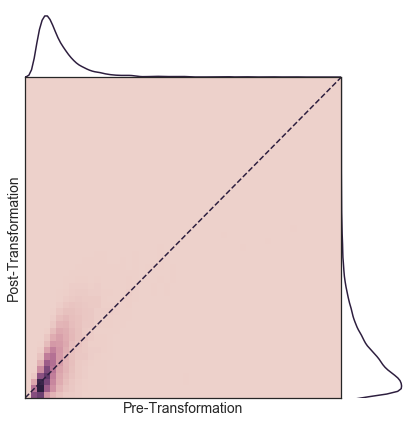

In [61]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_DCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_DCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

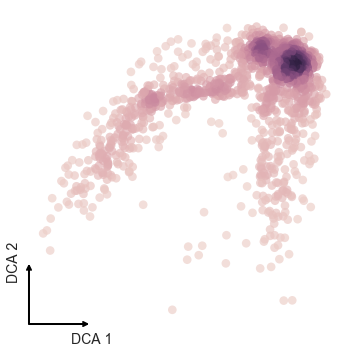

In [62]:
colon_DCA = DR.from_file('pymethods_out/colon_DCA.csv', name='DCA', labels=[None,None])
colon_DCA.plot()

In [63]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_DCA.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_DCA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['DCA'], final_distance_stats['Colon']['EMD']['DCA'], final_distance_stats['Colon']['KLD']['DCA'], final_distance_stats['Colon']['Knn Pres.']['DCA'] = mantel_stats[0], EMD, KLD, knn

R: 0.4957
EMD: 0.1543
KLD: 0.2146
Knn Pres.: 95.9836
CPU times: user 25 s, sys: 5.03 s, total: 30 s
Wall time: 30.1 s


CPU times: user 17.8 s, sys: 413 ms, total: 18.2 s
Wall time: 17.5 s


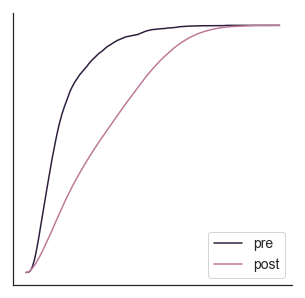

<Figure size 504x504 with 0 Axes>

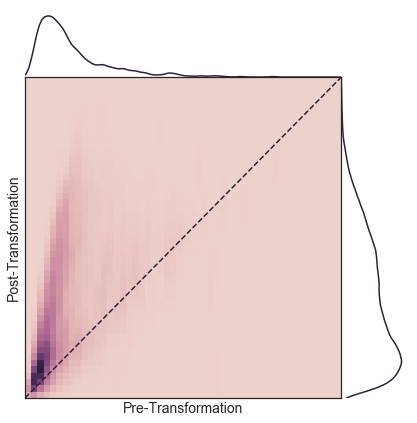

In [64]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_DCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_DCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# sc-VI
Here, we will plug counts data directly into sc-VI and compare results to the original, feature-selected dataset.

In [65]:
retina_scVI = DR.from_file('pymethods_out/retina_scVI.csv', name='scVI', labels=[None,None])

In [66]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_scVI.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_scVI.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['scVI'], final_distance_stats['Retina']['EMD']['scVI'], final_distance_stats['Retina']['KLD']['scVI'], final_distance_stats['Retina']['Knn Pres.']['scVI'] = mantel_stats[0], EMD, KLD, knn

R: 0.2454
EMD: 0.3371
KLD: 0.2054
Knn Pres.: 96.1521
CPU times: user 40.9 s, sys: 7.96 s, total: 48.8 s
Wall time: 48.9 s


CPU times: user 18.2 s, sys: 422 ms, total: 18.6 s
Wall time: 18.1 s


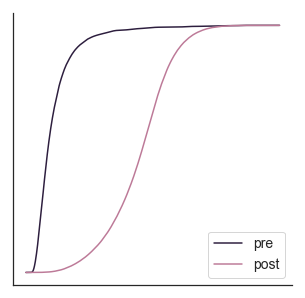

<Figure size 504x504 with 0 Axes>

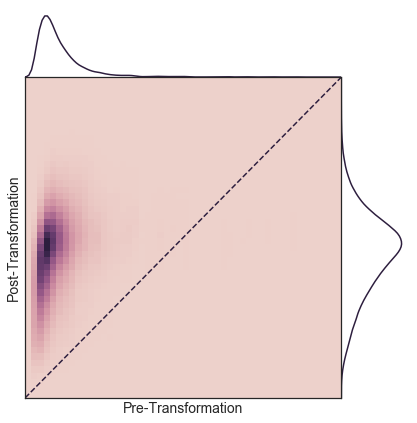

In [67]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_scVI_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_scVI_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [68]:
colon_scVI = DR.from_file('pymethods_out/colon_scVI.csv', name='scVI', labels=[None,None])

In [69]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_scVI.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_scVI.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['scVI'], final_distance_stats['Colon']['EMD']['scVI'], final_distance_stats['Colon']['KLD']['scVI'], final_distance_stats['Colon']['Knn Pres.']['scVI'] = mantel_stats[0], EMD, KLD, knn

R: 0.391
EMD: 0.2772
KLD: 0.2107
Knn Pres.: 95.6696
CPU times: user 27.2 s, sys: 5.8 s, total: 33 s
Wall time: 34.4 s


CPU times: user 18.3 s, sys: 511 ms, total: 18.8 s
Wall time: 18.1 s


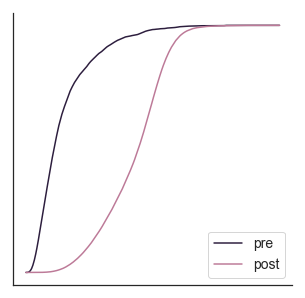

<Figure size 504x504 with 0 Axes>

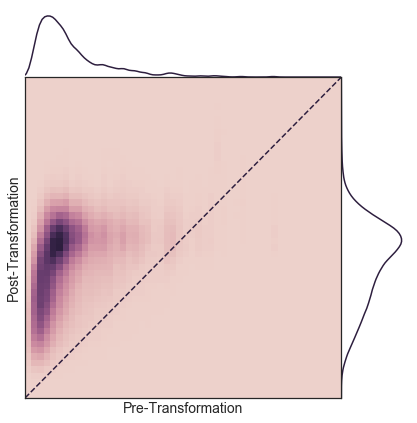

In [70]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_scVI_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_scVI_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# scvis
Here, we will plug counts data directly into scvis and compare results to the original, feature-selected dataset.

In [71]:
retina_scvis = DR.from_file(datafile='scvis_out/retina/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv',
                            labels=[0,0], name='scvis')

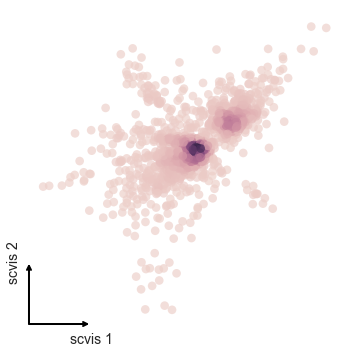

In [72]:
retina_scvis.plot()

In [73]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_scvis.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_scvis.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['scvis'], final_distance_stats['Retina']['EMD']['scvis'], final_distance_stats['Retina']['KLD']['scvis'], final_distance_stats['Retina']['Knn Pres.']['scvis'] = mantel_stats[0], EMD, KLD, knn

R: 0.7997
EMD: 0.0619
KLD: 0.0779
Knn Pres.: 97.7827
CPU times: user 38.6 s, sys: 7.64 s, total: 46.2 s
Wall time: 46.4 s


CPU times: user 17.8 s, sys: 457 ms, total: 18.3 s
Wall time: 17.7 s


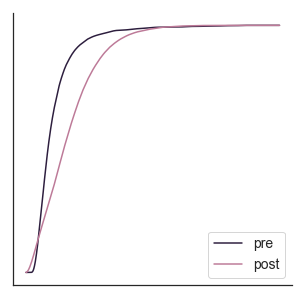

<Figure size 504x504 with 0 Axes>

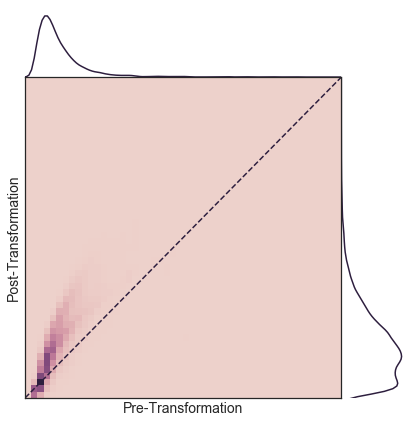

In [74]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_scvis_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_scvis_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [75]:
colon_scvis = DR.from_file(datafile='scvis_out/colon/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv',
                           labels=[0,0], name='scvis')

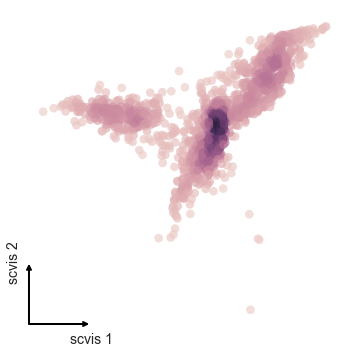

In [76]:
colon_scvis.plot()

In [77]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_scvis.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_scvis.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['scvis'], final_distance_stats['Colon']['EMD']['scvis'], final_distance_stats['Colon']['KLD']['scvis'], final_distance_stats['Colon']['Knn Pres.']['scvis'] = mantel_stats[0], EMD, KLD, knn

R: 0.77
EMD: 0.1175
KLD: 0.0963
Knn Pres.: 97.9649
CPU times: user 24 s, sys: 4.1 s, total: 28.1 s
Wall time: 28.1 s


CPU times: user 17.9 s, sys: 403 ms, total: 18.3 s
Wall time: 17.8 s


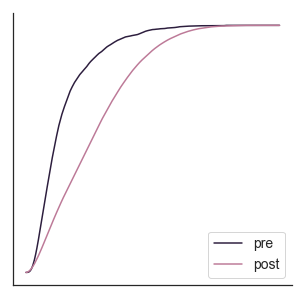

<Figure size 504x504 with 0 Axes>

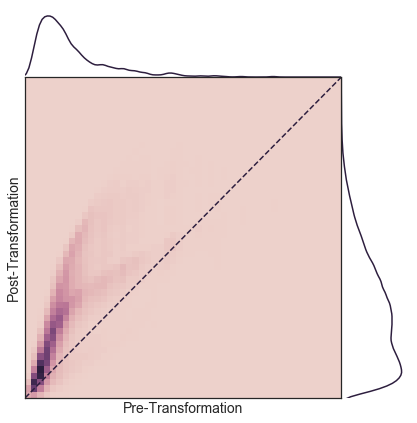

In [78]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_scvis_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_scvis_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# SIMLR
This method builds cell-cell similarity matrices to predict cluster number and assign cells to clusters based on similarity.
First, read in the `F` construct that consists of a c-dimensional output of length `n_cells`, where c is the number of expected clusters passed to SIMLR.  
Here, c was the number of clusters determined by Seurat Louvain algorithm.

In [79]:
retina_SIMLR = DR.from_file('Rmethods_out/retina_SIMLR_F.csv', name='SIMLR', labels=[None,0]) # read in low-dim space for comparison

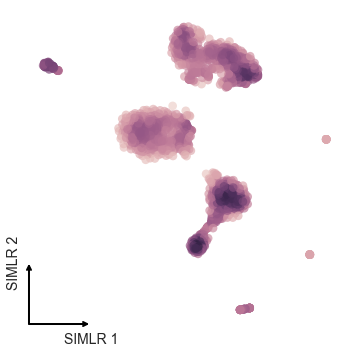

In [80]:
retina_SIMLR.plot()

In [81]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_SIMLR.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_SIMLR.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['SIMLR'], final_distance_stats['Retina']['EMD']['SIMLR'], final_distance_stats['Retina']['KLD']['SIMLR'], final_distance_stats['Retina']['Knn Pres.']['SIMLR'] = mantel_stats[0], EMD, KLD, knn

R: 0.526
EMD: 0.3275
KLD: 0.1824
Knn Pres.: 97.2329
CPU times: user 37.5 s, sys: 7.44 s, total: 45 s
Wall time: 45.8 s


CPU times: user 18.4 s, sys: 414 ms, total: 18.8 s
Wall time: 18.1 s


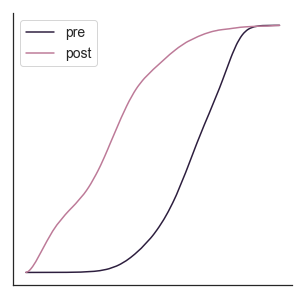

<Figure size 504x504 with 0 Axes>

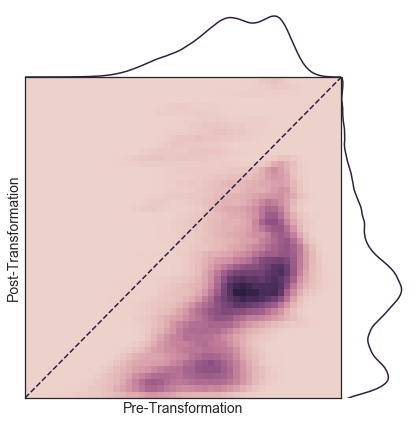

In [82]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_SIMLR_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_SIMLR_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [83]:
colon_SIMLR = DR.from_file('Rmethods_out/colon_SIMLR_F.csv', name='SIMLR', labels=[None,0]) # read in low-dim space for comparison

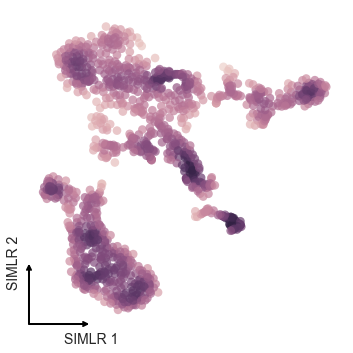

In [84]:
colon_SIMLR.plot()

In [85]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_SIMLR.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_SIMLR.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['SIMLR'], final_distance_stats['Colon']['EMD']['SIMLR'], final_distance_stats['Colon']['KLD']['SIMLR'], final_distance_stats['Colon']['Knn Pres.']['SIMLR'] = mantel_stats[0], EMD, KLD, knn

R: 0.7662
EMD: 0.0849
KLD: 0.0742
Knn Pres.: 96.8255
CPU times: user 23.7 s, sys: 4.6 s, total: 28.3 s
Wall time: 28.4 s


CPU times: user 18.2 s, sys: 372 ms, total: 18.6 s
Wall time: 17.9 s


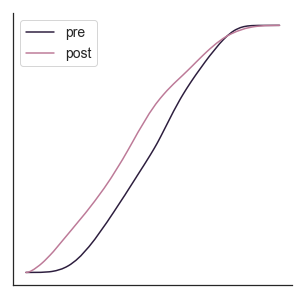

<Figure size 504x504 with 0 Axes>

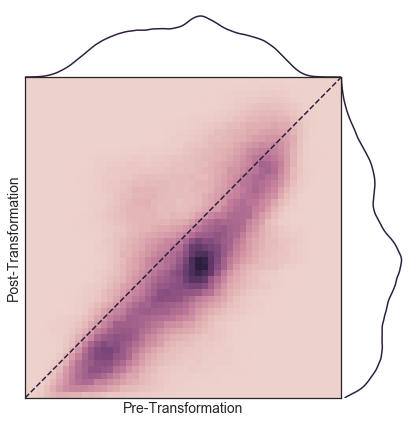

In [86]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_SIMLR_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_SIMLR_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
### ZINB-WAVE

In [87]:
retina_ZINBWAVE = DR.from_file('Rmethods_out/retina_ZINB-WAVE.csv', name='ZINB-WaVE', labels=[None,0])

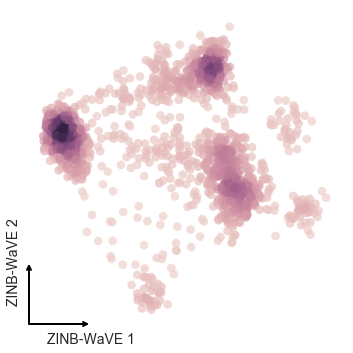

In [88]:
retina_ZINBWAVE.plot()

In [89]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_ZINBWAVE.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_ZINBWAVE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['ZINB-WaVE'], final_distance_stats['Retina']['EMD']['ZINB-WaVE'], final_distance_stats['Retina']['KLD']['ZINB-WaVE'], final_distance_stats['Retina']['Knn Pres.']['ZINB-WaVE'] = mantel_stats[0], EMD, KLD, knn

R: 0.2929
EMD: 0.2695
KLD: 0.2943
Knn Pres.: 96.1098
CPU times: user 39.7 s, sys: 7.94 s, total: 47.7 s
Wall time: 49.1 s


CPU times: user 18.4 s, sys: 453 ms, total: 18.9 s
Wall time: 18.8 s


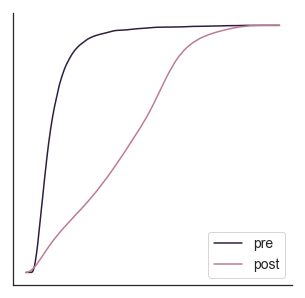

<Figure size 504x504 with 0 Axes>

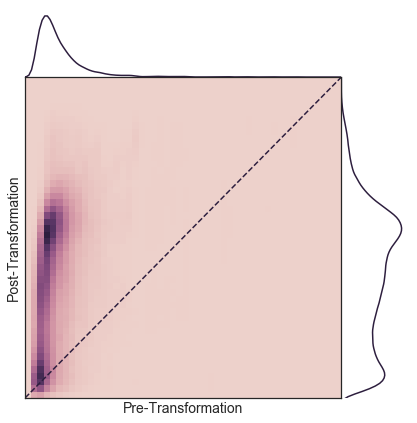

In [90]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_ZINBWAVE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_ZINBWAVE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [91]:
colon_ZINBWAVE = DR.from_file('Rmethods_out/colon_ZINB-WAVE.csv', name='ZINB-WaVE', labels=[None,0])

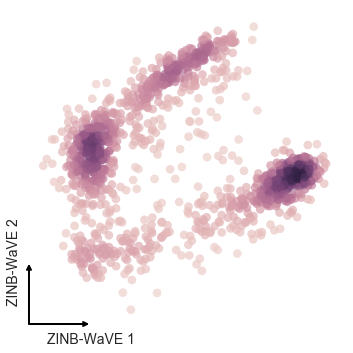

In [92]:
colon_ZINBWAVE.plot()

In [93]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_ZINBWAVE.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_ZINBWAVE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['ZINB-WaVE'], final_distance_stats['Colon']['EMD']['ZINB-WaVE'], final_distance_stats['Colon']['KLD']['ZINB-WaVE'], final_distance_stats['Colon']['Knn Pres.']['ZINB-WaVE'] = mantel_stats[0], EMD, KLD, knn

R: 0.36
EMD: 0.262
KLD: 0.2622
Knn Pres.: 95.7974
CPU times: user 25.7 s, sys: 4.56 s, total: 30.2 s
Wall time: 30.7 s


CPU times: user 18.4 s, sys: 416 ms, total: 18.8 s
Wall time: 18.7 s


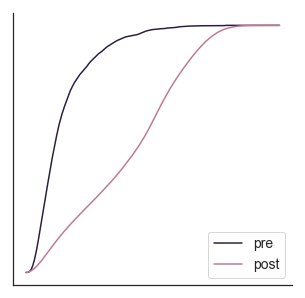

<Figure size 504x504 with 0 Axes>

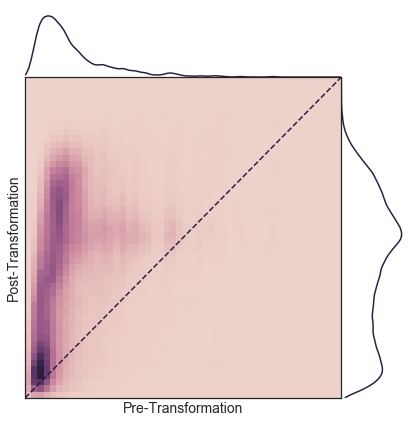

In [94]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_ZINBWAVE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_ZINBWAVE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
### GLM-PCA

In [95]:
retina_GLMPCA = DR.from_file('Rmethods_out/retina_GLM-PCA.csv', name='GLM-PC', labels=[None,0])

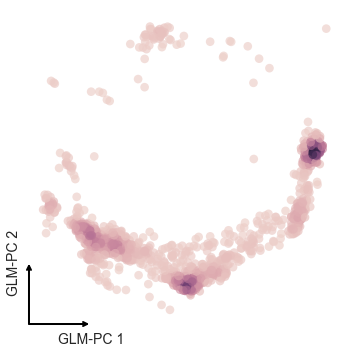

In [96]:
retina_GLMPCA.plot()

In [97]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_GLMPCA.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_GLMPCA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['GLM-PCA'], final_distance_stats['Retina']['EMD']['GLM-PCA'], final_distance_stats['Retina']['KLD']['GLM-PCA'], final_distance_stats['Retina']['Knn Pres.']['GLM-PCA'] = mantel_stats[0], EMD, KLD, knn

R: 0.2704
EMD: 0.2516
KLD: 0.3752
Knn Pres.: 96.0884
CPU times: user 38.7 s, sys: 6.95 s, total: 45.7 s
Wall time: 47.1 s


CPU times: user 18.3 s, sys: 453 ms, total: 18.7 s
Wall time: 18.2 s


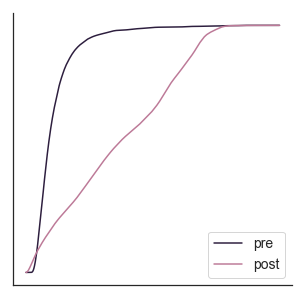

<Figure size 504x504 with 0 Axes>

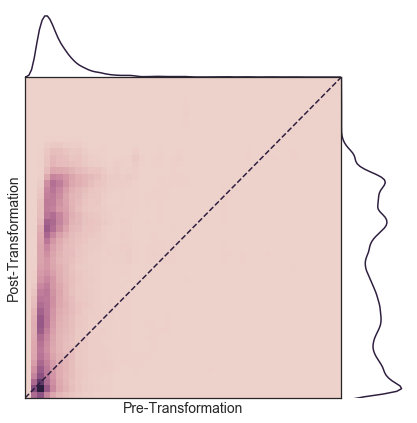

In [98]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_GLMPCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/retina_GLMPCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [99]:
colon_GLMPCA = DR.from_file('Rmethods_out/colon_GLM-PCA.csv', name='GLM-PC', labels=[None,0])

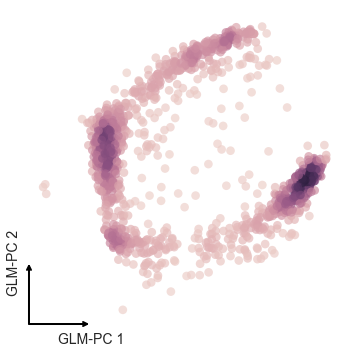

In [100]:
colon_GLMPCA.plot()

In [101]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_GLMPCA.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_GLMPCA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['GLM-PCA'], final_distance_stats['Colon']['EMD']['GLM-PCA'], final_distance_stats['Colon']['KLD']['GLM-PCA'], final_distance_stats['Colon']['Knn Pres.']['GLM-PCA'] = mantel_stats[0], EMD, KLD, knn

R: 0.3325
EMD: 0.244
KLD: 0.2779
Knn Pres.: 95.7796
CPU times: user 24.6 s, sys: 4.29 s, total: 28.9 s
Wall time: 29.2 s


CPU times: user 18 s, sys: 391 ms, total: 18.4 s
Wall time: 17.7 s


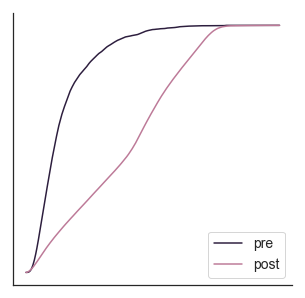

<Figure size 504x504 with 0 Axes>

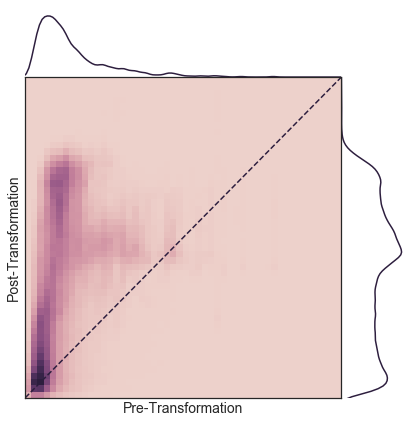

In [102]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_GLMPCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='../images/colon_GLMPCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
### Summary Metrics

In [103]:
retina_sum = pd.DataFrame(final_distance_stats['Retina'])
retina_sum = retina_sum.sort_values(by='R')
retina_sum = retina_sum.reindex(['EMD','KLD','R','Knn Pres.'], axis=1)
retina_sum.to_csv('retina_global_metrics.csv')

In [104]:
retina_sum = retina_sum.drop('KLD', axis=1) # dropping KL divergence

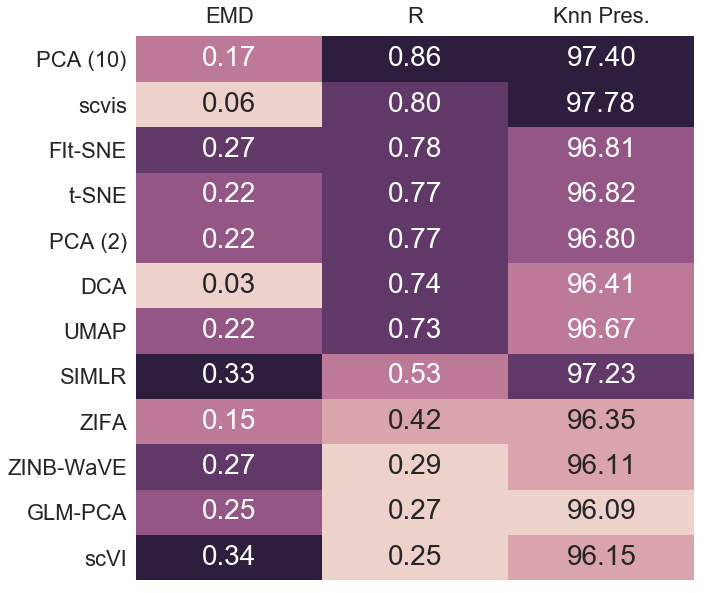

In [105]:
retina_norm=(retina_sum-retina_sum.mean())/retina_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(retina_norm, annot=retina_sum, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.tick_params(top=False)
plt.savefig(fname='../images/retina_global_metrics.png', transparent=True, bbox_inches='tight')

In [106]:
colon_sum = pd.DataFrame(final_distance_stats['Colon'])
colon_sum = colon_sum.sort_values(by='R')
colon_sum = colon_sum.reindex(['EMD','KLD','R','Knn Pres.'], axis=1)
colon_sum.to_csv('colon_global_metrics.csv')

In [107]:
colon_sum = colon_sum.drop('KLD', axis=1)

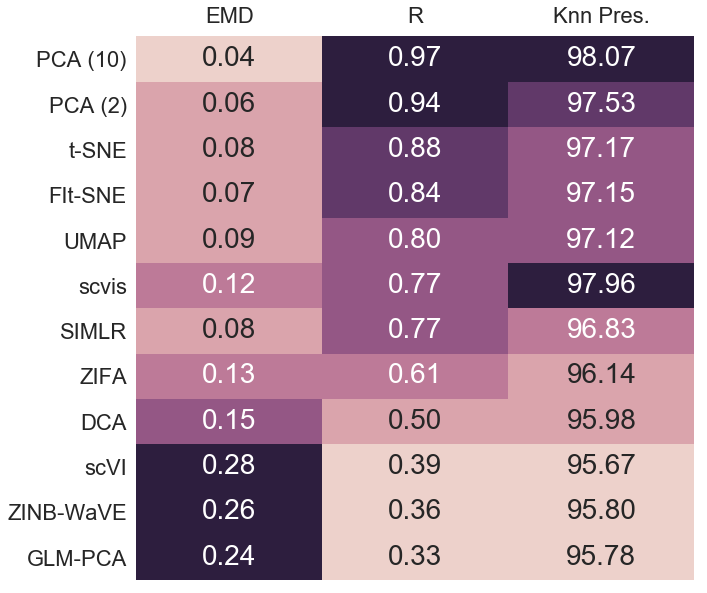

In [108]:
colon_norm=(colon_sum-colon_sum.mean())/colon_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
ax = sns.heatmap(colon_norm, annot=colon_sum, cmap=sns.cubehelix_palette(), robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.tick_params(top=False)
plt.savefig(fname='../images/colon_global_metrics.png', transparent=True, bbox_inches='tight')